## Learning Rate Schedulers with Skorch 

This notebook demonstrates 3 learning rate schedulers in skorch:

StepLR, ReduceROn Plateau and Cosine Annealing. This notebook was contributed by [Parag Ekbote](https://github.com/ParagEkbote).

Firstly you will need to install the following libraries: skorch,numpy,matplotlib and torch.

<table align="left"><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Learning_Rate_Scheduler.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Learning_Rate_Scheduler.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>


# Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler
from skorch.callbacks import Callback



## Data Preparation

The dataset will be split into train and test datasets. We will scale the features upto float 32 and labels reshaped for efficient binary classification.


In [2]:
def prepare_data():
    # Load the dataset
    data = load_breast_cancer()
    X, y = data.data, data.target
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
    X_test_scaled = scaler.transform(X_test).astype(np.float32)
    
    # Reshape the labels for compatibility
    y_train = y_train.astype(np.float32).reshape(-1, 1)
    y_test = y_test.astype(np.float32).reshape(-1, 1)
    
    return X_train_scaled, X_test_scaled, y_train, y_test
 

## Neural Net Parameters

The BreastCancerNet is a neural network designed for binary classification tasks. It consists of an input layer, two hidden layers with ReLU activation functions, and a single output layer. The architecture is parameterized to allow flexibility in adjusting the input and hidden layer dimensions.

In [3]:
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super(BreastCancerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


## Learning Rate Scheduler Parameters 

1) StepLR:

- Reduces the learning rate by a factor (gamma=0.3) every 100 epochs (step_size=10).
- Useful for steady, predictable learning rate decay.

2) ReduceLROnPlateau:

- Reduces the learning rate dynamically when the model's performance (e.g., loss) plateaus.
- Adjusts by a factor (factor=0.7) after 5 epochs of no improvement (patience=5).
- Ideal for tasks where loss stagnation indicates the need for smaller learning rates.

3) CosineAnnealing:

- Reduces the learning rate in a cosine curve over 10 epochs (T_max=10).
- Periodically resets the learning rate, promoting exploration of the loss landscape.

We will now train the neural network with different LR Schedulers.

In [5]:
class LRCaptureCallback(Callback):
    def on_epoch_end(self, net, **kwargs):
        # Log the learning rate of the optimizer
        lr = net.optimizer_.param_groups[0]['lr']
        if not hasattr(net.history, 'lr'):
            net.history.record('lr', lr)
        else:
            net.history[-1, 'lr'] = lr

# Training function with learning rate tracking 
def train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128):
    # Convert data to PyTorch tensors
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32).reshape(-1, 1)
    y_test = y_test.astype(np.float32).reshape(-1, 1)

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

    # Define learning rate schedulers
    schedulers = [
        {"name": "StepLR", "scheduler_class": torch.optim.lr_scheduler.StepLR, "params": {"step_size": 100, "gamma": 0.3}},
        {"name": "ReduceLROnPlateau", "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau, "params": {"mode": "max", "factor": 0.7, "patience": 5}},
        {"name": "CosineAnnealingLR", "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR, "params": {"T_max": 1000}},
    ]

    results = {}
    for scheduler_info in schedulers:
        print(f"\nTraining with {scheduler_info['name']} scheduler...")

        # Set up the neural network with the specified scheduler
        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.SGD,
            criterion=nn.BCEWithLogitsLoss,
            callbacks=[
                LRScheduler(
                    policy=scheduler_info["scheduler_class"],
                    **scheduler_info["params"]
                ),
                LRCaptureCallback(),
            ],
            iterator_train__shuffle=True,
            train_split=None,
            module__input_dim=X_train.shape[1],
            module__hidden_dim=hidden_dim,
            verbose=0
        )

        # Train the model
        net.fit(X_train, y_train)

        # Evaluate the model on the test set
        score = net.score(X_test, y_test)
        print(f"{scheduler_info['name']} Test Score: {score:.4f}")

        # Extract learning rates 
        lrs = [event['lr'] for event in net.history if 'lr' in event]
        print(f"{scheduler_info['name']} Recorded Learning Rates: {lrs[:5]}...")

        # Save results
        results[scheduler_info["name"]] = {
            "model": net,
            "learning_rates": lrs,
            "score": score,
        }

    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Test Score: {result['score']:.4f}")
        print(f"First 5 Learning Rates: {result['learning_rates'][:5]}")

    return results


# Generate synthetic data
X_train = np.random.rand(100, 30)
X_test = np.random.rand(40, 30)
y_train = np.random.randint(0, 2, size=(100,))
y_test = np.random.randint(0, 2, size=(40,))

# Train with schedulers and evaluate
results = train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128)


Training with StepLR scheduler...
StepLR Test Score: 0.4250
StepLR Recorded Learning Rates: [0.05, 0.05, 0.05, 0.05, 0.05]...

Training with ReduceLROnPlateau scheduler...
ReduceLROnPlateau Test Score: 0.5750
ReduceLROnPlateau Recorded Learning Rates: [0.05, 0.05, 0.05, 0.05, 0.05]...

Training with CosineAnnealingLR scheduler...
CosineAnnealingLR Test Score: 0.5250
CosineAnnealingLR Recorded Learning Rates: [0.04999987663004646, 0.049999506521403426, 0.04999888967772375, 0.04999802610509541, 0.04999691581204153]...

Final Results Summary:

Scheduler: StepLR
Test Score: 0.4250
First 5 Learning Rates: [0.05, 0.05, 0.05, 0.05, 0.05]

Scheduler: ReduceLROnPlateau
Test Score: 0.5750
First 5 Learning Rates: [0.05, 0.05, 0.05, 0.05, 0.05]

Scheduler: CosineAnnealingLR
Test Score: 0.5250
First 5 Learning Rates: [0.04999987663004646, 0.049999506521403426, 0.04999888967772375, 0.04999802610509541, 0.04999691581204153]


# Visualization of Results

We observe the following Results:

1) StepLR reduces the learning rate in fixed steps, ReduceLROnPlateau adaptively lowers it when progress stagnates, and CosineAnnealing follows a periodic decay to explore new minima. 

2) Choosing the right scheduler depends on task requirements, with StepLR suited for predefined decays, ReduceLROnPlateau for dynamic adjustments, and CosineAnnealing for periodic resets to escape local minima.

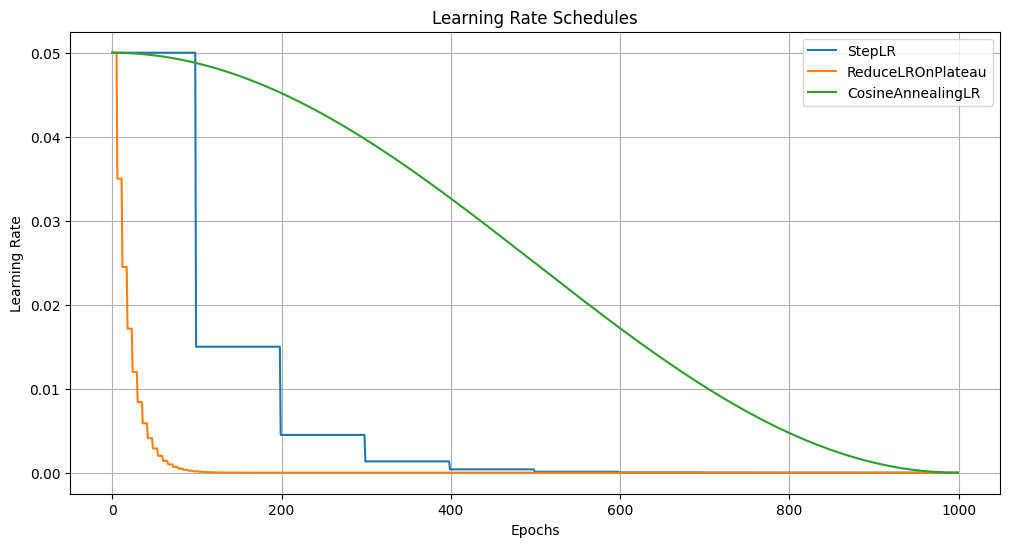

In [6]:
def plot_results(results):
    plt.figure(figsize=(12, 6))
    
    for scheduler_name, result in results.items():
        # Extract learning rates 
        learning_rates = result["model"].history[:, 'lr']
        plt.plot(learning_rates, label=scheduler_name)
    
    plt.title("Learning Rate Schedules")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(results)
